In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [4]:
# Load the Titanic dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
# Define a function to count null values in a DataFrame
def count_null(df):
    null_df = pd.DataFrame(df.isnull().sum(), columns=["Count"])
    display(null_df[null_df["Count"] > 0])

In [6]:
# Display the summary of null values in the dataset
def null_summary():
    data = [train, test]
    for dataset in data:
        count_null(dataset)

In [7]:
# Concatenate train and test data for preprocessing
all_data = pd.concat([train, test])

In [8]:
# Fill missing values in the 'Embarked' column with the mode
train["Embarked"].fillna(all_data["Embarked"].mode()[0], inplace=True)

In [9]:
# Fill missing values in the 'Fare' column with the median
test["Fare"].fillna(all_data["Fare"].median(), inplace=True)

In [10]:
# Assign cabin deck based on the first letter of 'Cabin' value
def assign_cabin(deck):
    if deck in ["A", "B", "C", "T"]:
        return "ABC"
    elif deck in ["D", "E"]:
        return "DE"
    elif deck in ["F", "G"]:
        return "FG"
    else:
        return "U"

In [11]:
# Modify 'Cabin' column to contain the assigned cabin deck
for df in [train, test]:
    df["HasCabin"] = df["Cabin"].notnull()
    df["Cabin"] = df["Cabin"].fillna("U")
    df["Cabin"] = df["Cabin"].str[0].map(assign_cabin)

In [12]:
# Assign titles to passengers based on their name
def assign_title(title):
    if title in ["Miss", "Mlle", "Ms"]:
        return "Miss"
    elif title in ["Mrs", "Mme"]:
        return "Mrs"
    elif title in ["Lady", "the Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]:
        return "Rare"
    else:
        return title

In [13]:
# Modify 'Title' column to contain the assigned title
for df in [train, test]:
    df["Title"] = df["Name"].apply(lambda x: x.split(', ')[1].split('.')[0])
    df["Title"] = df["Title"].apply(assign_title)

In [14]:
# Create 'FamilySize' and 'Is_Alone' columns based on 'Parch' and 'SibSp'
for df in [train, test]:
    df["FamilySize"] = df["Parch"] + df["SibSp"]
    df["Is_Alone"] = df["FamilySize"] == 0

In [15]:
# Concatenate train and test data for preprocessing
all_data = pd.concat([train, test])

In [16]:
# Group passengers by 'Title' and 'Pclass' and calculate the mean age
grouped_age = all_data.groupby(["Title", "Pclass"])["Age"].agg(["mean", "count"])

In [17]:
# Fill missing age values based on 'Title' and 'Pclass'
for df in [train, test]:
    df["Age"] = df.apply(lambda x: grouped_age.loc[(x["Title"], x["Pclass"])]["mean"] if pd.isnull(x["Age"]) else x["Age"], axis=1)

In [18]:
# Drop unnecessary columns
for df in [train, test]:
    df.drop("Ticket", axis=1, inplace=True)
    df.drop("Name", axis=1, inplace=True)

In [19]:
# Normalize 'Fare' using StandardScaler
combined_fare = all_data["Fare"]
train_fare = train["Fare"]
test_fare = test["Fare"]
scaler = StandardScaler()
normalized_combined_fare = scaler.fit_transform(combined_fare.values.reshape(-1, 1))
normalized_train_fare = scaler.transform(train_fare.values.reshape(-1, 1))
normalized_test_fare = scaler.transform(test_fare.values.reshape(-1, 1))
all_data["Fare"] = normalized_combined_fare
train["Fare"] = normalized_train_fare
test["Fare"] = normalized_test_fare

In [20]:
# Normalize 'Age' using StandardScaler
combined_age = all_data["Age"]
train_age = train["Age"]
test_age = test["Age"]
age_scaler = StandardScaler()
normalized_combined_age = age_scaler.fit_transform(combined_age.values.reshape(-1, 1))
normalized_train_age = age_scaler.transform(train_age.values.reshape(-1, 1))
normalized_test_age = age_scaler.transform(test_age.values.reshape(-1, 1))
all_data["Age"] = normalized_combined_age
train["Age"] = normalized_train_age
test["Age"] = normalized_test_age

In [21]:
# Encode categorical string columns using LabelEncoder
string_columns = ["Sex", "Cabin", "Embarked", "HasCabin", "Is_Alone", "Title"]
for col in string_columns:
    label_encoder = LabelEncoder()
    all_data[col] = label_encoder.fit_transform(all_data[col])
    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [22]:
# Split the dataset into train, cross-validation, and test sets
train_X, cross_X, train_Y, cross_Y = train_test_split(train.drop(["PassengerId", "Survived"], axis=1), train["Survived"], test_size=0.2)

In [23]:
# Define the neural network model
model = Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dense(7, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ], name="my_model"
)

In [24]:
# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

In [28]:
# Train the model
history = model.fit(
    train_X, train_Y,
    epochs=1000,
    verbose=0,
    validation_data=(cross_X, cross_Y)
)

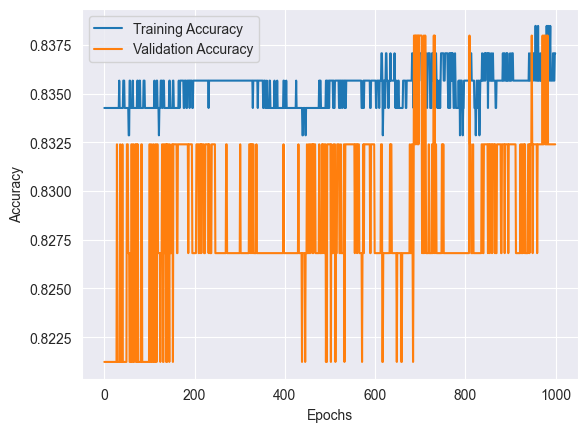

In [29]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

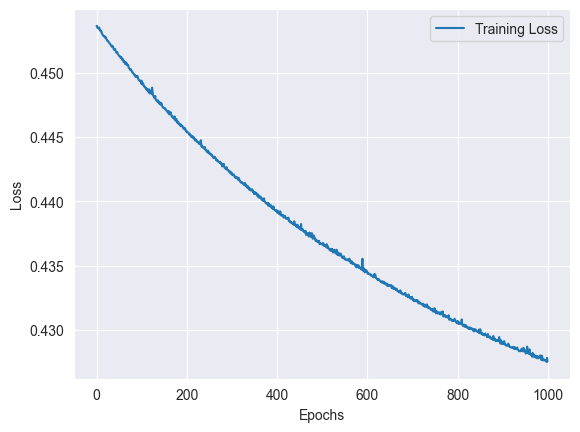

In [30]:
# Plot training loss
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
# Make predictions on the test set
test_Pid = test["PassengerId"]
predictions = model.predict(test.drop("PassengerId", axis=1))

14/14 [==============================] - 0s 3ms/step


In [32]:
# Convert probability predictions to binary predictions
binary_predictions = np.where(predictions >= 0.5, 1, 0)

In [33]:
# Create a DataFrame with the predicted survival values
binary_predictions_df = pd.DataFrame(binary_predictions, columns=["Survived"])

In [34]:
# Merge the PassengerId and predicted survival values
merged_df = pd.concat([test_Pid, binary_predictions_df], axis=1)

In [35]:
# Save the predictions to a CSV file
merged_df.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [36]:
# Calculate accuracy
actual = pd.read_csv("submission.csv")
accuracy = accuracy_score(actual["Survived"], binary_predictions_df)
print("Accuracy:", accuracy)

Accuracy: 1.0
